In [8]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
#import advanced_functions as advance
import stumps
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_curve, auc

In [2]:
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_data.csv")
x = data.loc[:,:'five_year']
y = data['recid_violent2'].values

### CART & EBM

In [ ]:
#### CART
depth = [1,2,3]
impurity = [0.001, 0.003]
split = [2,3,4]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         split=split,
                         impurity=impurity, 
                         seed = 816)

#### GAM
estimators = [20]
depth = [1]
learning_rate = [0.05]
holdout_split = [0.9]
gam_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate = learning_rate,
                       depth = depth,
                       estimators=estimators,
                       holdout_split=holdout_split,
                       seed=816)

### Lasso Stumps

In [5]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
#data = data.drop(['person_id', 'screening_date'], axis=1)
X_stumps, Y_stumps = data.loc[:,:'five_year>=1'], data['recid_violent2'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns

In [6]:
cols

Index(['sex>=1', 'p_current_age>=18', 'p_current_age>=19', 'p_current_age>=23',
       'p_current_age>=27', 'p_current_age>=29', 'p_current_age>=30',
       'p_current_age>=31', 'p_current_age>=33', 'p_current_age>=37',
       ...
       'years_since_last_crime>=2.5', 'years_since_last_crime>=3',
       'years_since_last_crime>=3.5', 'years_since_last_crime>=4',
       'years_since_last_crime>=4.5', 'years_since_last_crime>=5',
       'six_month>=1', 'one_year>=1', 'three_year>=1', 'five_year>=1'],
      dtype='object', length=158)

In [13]:
### stumps model
alpha = [0.02]
Stump = stumps.stump_features(X_stumps, Y_stumps, cols, alpha, 816)

In [14]:
np.mean(Stump['test_auc']), np.mean(Stump['train_auc']), Stump['auc_diff']

(0.6821317892049418, 0.6827389093740835, 0.02475639528531237)

In [15]:
stumps.stump_table(Stump['coefs'], Stump['features'], Stump['intercept'], Stump['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| p_age_first_offense<=19           | 0.018          |
| current_violent>=1                | 0.02           |
| violent_conviction>=3             | 0.055          |
| p_property>=1                     | 0.0            |
| p_stealing>=3                     | 0.024          |
| years_since_last_crime>=1         | -0.008         |
| Intercept                         | 0.177          |
|====================================================|
| ADD POINTS FROM ROWS 1 TO 6      | Total Score    |
+-----------------------------------+----------------+


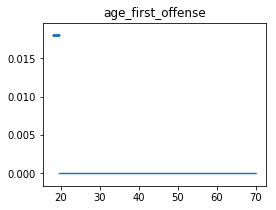

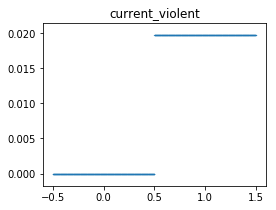

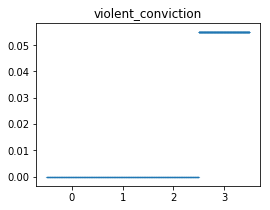

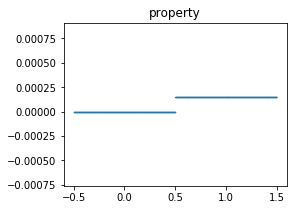

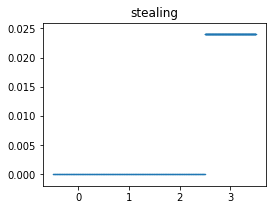

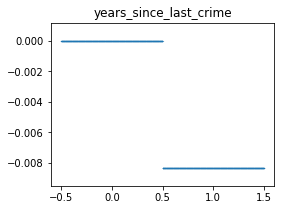

In [17]:
stumps.stump_plots(Stump['features'], Stump['coefs'])

### Arnold PSA

In [30]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_arnold.csv")
X_arnold_raw = data['arnold_nvca_raw'].values
Y_arnold = data['recid_violent2'].values

In [38]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_test = X_arnold_raw[test], Y_arnold[test]
    raw_fpr, raw_tpr, raw_thresholds = roc_curve(y_test, y_pred_raw)
    raw_auc.append(auc(raw_fpr, raw_tpr))
    i+=1 

### Results

In [23]:
results = [["EBM", ebm_summary['best_validation_auc'], ebm_summary['best_validation_std'], ebm_summary['best_param']], 
           ['Lasso Stumps', round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3)], 
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]

In [24]:
results

[['AdaBoost',
  0.6438730033461224,
  0.018642382119523626,
  {'learning_rate': 0.05, 'n_estimators': 10}],
 ['EBM',
  0.6596007200011168,
  0.02375994427912098,
  {'holdout_split': 0.9,
   'learning_rate': 0.03,
   'max_tree_splits': 1,
   'n_estimators': 40}],
 ['Lasso Stumps', 0.674, 0.007],
 ['Arnold PSA Raw', 0.611, 0.045],
 ['Arnold PSA', 0.605, 0.043]]

In [41]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model results/Advanced Models/Two Year/"
results = [["Violent", round(ebm_summary['best_validation_auc'],3), round(ebm_summary['best_validation_std'], 3), round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3), round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3), round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]
with open(path + 'Advanced Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)